In [1]:
# %%
import pandas as pd
import os


In [2]:
# %%
mcsa_row_path = '../dataset/raw_dataset/mcsa/'
dataset_path = '../dataset/mcsa_fine_tune/normal_mcsa/'
structure_path = '../dataset/mcsa_fine_tune/structures/'


In [3]:
# %%
import subprocess

# 定义CD-HIT命令和参数

def run_subprocess_and_print(args):
    # 开启一个新的进程
    with subprocess.Popen(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True) as proc:
        # 实时读取输出
        while True:
            output = proc.stdout.readline()
            if output == '' and proc.poll() is not None:
                break
            if output:
                print(output.strip())  # 输出每一行
        # 检查错误输出
        err = proc.stderr.read()
        if err:
            print("Error:", err)
    proc.communicate()

threshold = [0.8, 0.6, 0.4]
command = "/home/xiaoruiwang/software/cdhit/cd-hit"
for thre in threshold:

    if thre < 0.5:
        word = 2
    elif thre < 0.6:
        word = 3
    elif thre < 0.7:
        word = 4
    else:
        word = 5
    args = ["-i", os.path.abspath(os.path.join(mcsa_row_path, 'ec_react_100_train_and_mcsa_sequence.fasta')),
            "-o", os.path.abspath(os.path.join(mcsa_row_path, f'ec_react_100_train_and_mcsa_sequence_cutoff_{str(thre)}.fasta')), 
            "-c", str(thre),
            "-n", str(word),
            "-T", str(12)]
    print('Args: {}'.format(' '.join(args)))
    if not os.path.exists(os.path.abspath(os.path.join(mcsa_row_path, f'ec_react_100_train_and_mcsa_sequence_cutoff_{str(thre)}.fasta'))):
        run_subprocess_and_print([command] + args)


Args: -i /home/xiaoruiwang/data/ubuntu_work_beta/single_step_work/EasIFA_v2/dataset/raw_dataset/mcsa/ec_react_100_train_and_mcsa_sequence.fasta -o /home/xiaoruiwang/data/ubuntu_work_beta/single_step_work/EasIFA_v2/dataset/raw_dataset/mcsa/ec_react_100_train_and_mcsa_sequence_cutoff_0.8.fasta -c 0.8 -n 5 -T 12
Args: -i /home/xiaoruiwang/data/ubuntu_work_beta/single_step_work/EasIFA_v2/dataset/raw_dataset/mcsa/ec_react_100_train_and_mcsa_sequence.fasta -o /home/xiaoruiwang/data/ubuntu_work_beta/single_step_work/EasIFA_v2/dataset/raw_dataset/mcsa/ec_react_100_train_and_mcsa_sequence_cutoff_0.6.fasta -c 0.6 -n 4 -T 12
Args: -i /home/xiaoruiwang/data/ubuntu_work_beta/single_step_work/EasIFA_v2/dataset/raw_dataset/mcsa/ec_react_100_train_and_mcsa_sequence.fasta -o /home/xiaoruiwang/data/ubuntu_work_beta/single_step_work/EasIFA_v2/dataset/raw_dataset/mcsa/ec_react_100_train_and_mcsa_sequence_cutoff_0.4.fasta -c 0.4 -n 2 -T 12


In [4]:
# %%
from collections import defaultdict
def get_cluster(cluster_results_path):
    results = defaultdict(list)
    with open(cluster_results_path, 'r', encoding='utf-8') as f:
        data = [x.strip() for x in f.readlines()]
    for line in data:
        if '>Cluster' in line:
            cluster = line.replace('>', '')
            continue
        alphadb_id = line.split('>')[-1].split('.')[0]
        results[cluster].append(alphadb_id)
    return results


def id2cluster(cluster_results:dict):
    alphafold_id2cluster = {}
    for key in cluster_results:
        for id in cluster_results[key]:
            alphafold_id2cluster[id] = key
    return alphafold_id2cluster



In [5]:
# %%
threshold = threshold
alphafold_id2cluster_all_levels = {}
cluster_all_levels2alphafold_id = {}
for thre in threshold:
    cluster_results_path = os.path.abspath(os.path.join(mcsa_row_path, f'ec_react_100_train_and_mcsa_sequence_cutoff_{str(thre)}.fasta.clstr'))
    cluster_results = get_cluster(cluster_results_path)
    print(len(cluster_results))
    alphafold_id2cluster_all_levels[thre] = id2cluster(cluster_results)
    cluster_all_levels2alphafold_id[thre] = cluster_results


27496
17582
7865


In [6]:
# %%
from tqdm import tqdm
import pandas as pd
import os
from tqdm.auto import tqdm
from pandarallel import pandarallel
from rdkit import Chem
from tqdm import tqdm as top_tqdm

def get_structure_sequence(pdb_file):
    try:
        mol = Chem.MolFromPDBFile(pdb_file)
        protein_sequence = Chem.MolToSequence(mol)
    except:
        protein_sequence = ''
    return protein_sequence
def multiprocess_structure_check(df, nb_workers, pdb_file_path):
    
    if nb_workers != 0:

        pandarallel.initialize(nb_workers=nb_workers, progress_bar=True)
        df['pdb_files'] = df['alphafolddb-id'].parallel_apply(
            lambda x: os.path.join(pdb_file_path, f'AF-{x}-F1-model_v4.pdb'))
        df['aa_sequence_calculated'] = df['pdb_files'].parallel_apply(
            lambda x: get_structure_sequence(x))
    else:
        top_tqdm.pandas(desc='pandas bar')
        df['pdb_files'] = df['alphafolddb-id'].progress_apply(
            lambda x: os.path.join(pdb_file_path, f'AF-{x}-F1-model_v4.pdb'))
        df['aa_sequence_calculated'] = df['pdb_files'].progress_apply(
            lambda x: get_structure_sequence(x))
    
    df['is_valid'] = (df['aa_sequence_calculated'] == df['aa_sequence'])

    return df
def get_query_database(path, fasta_path, pdb_file_path):
    database_df = pd.read_csv(path)
    database_df = database_df[['alphafolddb-id', 'aa_sequence','site_labels', 'site_types']]
    database_df['alphafolddb-id'] = database_df['alphafolddb-id'].apply(lambda x:x.replace(';',''))
    
    database_df = multiprocess_structure_check(database_df, nb_workers=12, pdb_file_path=pdb_file_path)
    
    write_database_df = database_df.drop_duplicates(subset=['alphafolddb-id', 'aa_sequence','site_labels', 'site_types']).reset_index(drop=True)


    with open(fasta_path, 'w', encoding='utf-8') as f:
        for idx, row in tqdm(write_database_df.iterrows(), total=len(write_database_df)):
            f.write('>{}\n'.format(row['alphafolddb-id']))
            f.write('{}\n'.format(row['aa_sequence']))
    return database_df




In [7]:
import pandas as pd
from Bio import SeqIO

def fasta_to_dataframe(fasta_file):
    # 创建空列表用于存储序列数据
    ids = []
    sequences = []
    
    # 使用BioPython的SeqIO解析fasta文件
    for record in SeqIO.parse(fasta_file, "fasta"):
        # 将序列ID和序列数据分别加入到列表中
        ids.append(record.id)
        sequences.append(str(record.seq))
    
    # 使用pandas创建DataFrame
    df = pd.DataFrame({
        'alphafolddb-id': ids,
        'aa_sequence': sequences
    })
    
    return df

In [8]:

ec_react_100_train_and_mcsa_sequence_df = fasta_to_dataframe(os.path.join(mcsa_row_path, 'ec_react_100_train_and_mcsa_sequence.fasta'))
ec_react_100_train_and_mcsa_sequence_df

,alphafolddb-id,aa_sequence
0,P56868,MKIGIFDSGVGGLTVLKAIRNRYRKVDIVYLGDTARVPYGIRSKDT...
1,P62593,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
2,P15559,MVGRRALIVLAHSERTSFNYAMKEAAAAALKKKGWEVVESDLYAMN...
3,P25006,MTEQLQMTRRTMLAGAALAGAVAPLLHTAQAHAAGAAAAAGAAPVD...
4,P08819,VEPSGHAADRIARLPGQPAVDFDMYSGYITVDEGAGRSLFYLLQEA...
...,...,...
45579,A0A3Q7HBJ5,MELLYVCLVCVFVFLVSLLLLYKKKSGEGLPPGKTGWPVFGESLEF...
45580,A5BFI4,MEVFFLSLLLICVLSVSIRLYLLLYKHRSHFTGPNLPPGKIGWPMV...
45581,F6H9N6,MEVFFLSLLLIFVLSVSIGLHLLFYKHRSHFTGPNLPPGKIGWPMV...
45582,A0A0U2U8U5,MYLTILFLFVSSILLSLMFLLRKHLSHFSYQNLPPGKTGFPLIGES...


In [9]:
train_dataset = get_query_database(os.path.join(dataset_path, 'train_dataset', 'mcsa_train.csv'), fasta_path=os.path.join(dataset_path, 'train_dataset_check.fasta'), pdb_file_path=os.path.join(structure_path,'alphafolddb_download'))
train_dataset

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


  0%|          | 0/771 [00:00<?, ?it/s]

,alphafolddb-id,aa_sequence,site_labels,site_types,pdb_files,aa_sequence_calculated,is_valid
0,P62593,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,"[[68], [71], [128], [164], [232], [235]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,True
1,P15559,MVGRRALIVLAHSERTSFNYAMKEAAAAALKKKGWEVVESDLYAMN...,"[[150], [156], [162]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MVGRRALIVLAHSERTSFNYAMKEAAAAALKKKGWEVVESDLYAMN...,True
2,P00390,MALLPRALSAGAGPSWRRAARAFRGFLLLLPEPAALTRALSRAMAC...,"[[102], [107], [110], [241], [245], [511], [516]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MALLPRALSAGAGPSWRRAARAFRGFLLLLPEPAALTRALSRAMAC...,True
3,P9WJJ7,MGLSDWELAAARAAIARGLDEDLRYGPDVTTLATVPASATTTASLV...,"[[105], [140], [172], [201], [222]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MGLSDWELAAARAAIARGLDEDLRYGPDVTTLATVPASATTTASLV...,True
4,P31153,MNGQLNGFHEAFIEEGTFLFTSESVGEGHPDKICDQISDAVLDAHL...,"[[29], [31], [32], [57], [70], [181], [250], [...",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MNGQLNGFHEAFIEEGTFLFTSESVGEGHPDKICDQISDAVLDAHL...,True
...,...,...,...,...,...,...,...
768,Q12BV1,MNGKIALEEHFATEETLMDSAGFVPDKDWPELRSRLLDIQDRRVRL...,"[[8], [10], [164], [287]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MNGKIALEEHFATEETLMDSAGFVPDKDWPELRSRLLDIQDRRVRL...,True
769,Q9Y3Z3,MQRADSEQPSKRPRCDDSPRTPSNTPSAEADWSPGLELHPDYKTWG...,"[[149], [167], [206], [207], [210], [215], [21...",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MQRADSEQPSKRPRCDDSPRTPSNTPSAEADWSPGLELHPDYKTWG...,True
770,P45850,SDPDPLQDFCVADLDGKAVSVNGHTCKPMSEAGDDFLFSSKLTKAG...,"[[75], [77], [85], [88], [90], [95], [137], [1...",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,SDPDPLQDFCVADLDGKAVSVNGHTCKPMSEAGDDFLFSSKLTKAG...,True
771,I0JWN7,MTVKLKKPKKYAVAKNATLLAAFGLIGSLSLAKANDELIKLEKEPG...,"[[206], [290], [333], [335]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MTVKLKKPKKYAVAKNATLLAAFGLIGSLSLAKANDELIKLEKEPG...,True


In [10]:
# %%

test_dataset = get_query_database(os.path.join(dataset_path, 'test_dataset', 'mcsa_test.csv'), fasta_path=os.path.join(dataset_path, 'test_dataset_check.fasta'), pdb_file_path=os.path.join(structure_path,'alphafolddb_download'))
test_dataset = test_dataset.loc[test_dataset['is_valid']].reset_index(drop=True)
test_dataset




INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


  0%|          | 0/95 [00:00<?, ?it/s]

,alphafolddb-id,aa_sequence,site_labels,site_types,pdb_files,aa_sequence_calculated,is_valid
0,P07598,MSRTVMERIEYEMHTPDPKADPDKLHFVQIDEAKCIGCDTCSQYCP...,"[[156], [159], [178], [198], [237], [240], [24...",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MSRTVMERIEYEMHTPDPKADPDKLHFVQIDEAKCIGCDTCSQYCP...,True
1,P00436,MPIELLPETPSQTAGPYVHIGLALEAAGNPTRDQEIWNRLAKPDAP...,"[[109], [148], [158], [161], [163]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MPIELLPETPSQTAGPYVHIGLALEAAGNPTRDQEIWNRLAKPDAP...,True
2,Q55389,MTSSDTQNNKTLAAMKNFAEQYAKRTDTYFCSDLSVTAVVIEGLAR...,"[[56], [58], [75], [77], [86], [87], [88]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MTSSDTQNNKTLAAMKNFAEQYAKRTDTYFCSDLSVTAVVIEGLAR...,True
3,P68688,MQTVIFGRSGCPYCVRAKDLAEKLSNERDDFQYQYVDIRAEGITKE...,"[[8], [10], [11], [13], [14], [18], [72]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MQTVIFGRSGCPYCVRAKDLAEKLSNERDDFQYQYVDIRAEGITKE...,True
4,P0A006,MDKKTIYFICTGNSCRSQMAEGWGKEILGEGWNVYSAGIETHGVNP...,"[[10], [11], [12], [13], [14], [15], [16], [17...",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MDKKTIYFICTGNSCRSQMAEGWGKEILGEGWNVYSAGIETHGVNP...,True
...,...,...,...,...,...,...,...
77,P42126,MALVASVRVPARVLLRAGARLPGAALGRTERAAGGGDGARRFGSQR...,"[[108], [153], [177], [178]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MALVASVRVPARVLLRAGARLPGAALGRTERAAGGGDGARRFGSQR...,True
78,P27001,MLEEALAAIQNARDLEELKALKARYLGKKGLLTQEMKGLSALPLEE...,"[[149], [178], [204], [218], [261], [314]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MLEEALAAIQNARDLEELKALKARYLGKKGLLTQEMKGLSALPLEE...,True
79,P22106,MCSIFGVFDIKTDAVELRKKALELSRLMRHRGPDWSGIYASDNAIL...,"[[2], [51], [75], [76], [322], [325]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MCSIFGVFDIKTDAVELRKKALELSRLMRHRGPDWSGIYASDNAIL...,True
80,P46849,MKRMIALDGAQGEGGGQILRSALSLSMITGQPFTITSIRAGRAKPG...,"[[13], [308]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MKRMIALDGAQGEGGGQILRSALSLSMITGQPFTITSIRAGRAKPG...,True


In [11]:
def id_handle(id, name_dict):
    if id not in name_dict:
        return name_dict[f' {id}']
    return name_dict[id]


for thre in threshold:
    # ec_react_100_train_and_mcsa_sequence_df[f'cluster_ther_{str(thre)}'] = ec_react_100_train_and_mcsa_sequence_df['alphafolddb-id'].apply(lambda x:alphafold_id2cluster_all_levels[thre][x.replace(';', '')])
    train_dataset[f'cluster_ther_{str(thre)}'] = train_dataset['alphafolddb-id'].apply(lambda x:id_handle(x.replace(';', ''), alphafold_id2cluster_all_levels[thre]))
    # test_dataset[f'cluster_ther_{str(thre)}'] = test_dataset['alphafolddb-id'].apply(lambda x:alphafold_id2cluster_all_levels[thre][x.replace(';', '')])
    test_dataset[f'cluster_ther_{str(thre)}'] = test_dataset['alphafolddb-id'].apply(lambda x:id_handle(x.replace(';', ''), alphafold_id2cluster_all_levels[thre]))

In [12]:
train_dataset

,alphafolddb-id,aa_sequence,site_labels,site_types,pdb_files,aa_sequence_calculated,is_valid,cluster_ther_0.8,cluster_ther_0.6,cluster_ther_0.4
0,P62593,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,"[[68], [71], [128], [164], [232], [235]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,True,Cluster 18632,Cluster 11874,Cluster 5221
1,P15559,MVGRRALIVLAHSERTSFNYAMKEAAAAALKKKGWEVVESDLYAMN...,"[[150], [156], [162]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MVGRRALIVLAHSERTSFNYAMKEAAAAALKKKGWEVVESDLYAMN...,True,Cluster 19381,Cluster 12378,Cluster 5791
2,P00390,MALLPRALSAGAGPSWRRAARAFRGFLLLLPEPAALTRALSRAMAC...,"[[102], [107], [110], [241], [245], [511], [516]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MALLPRALSAGAGPSWRRAARAFRGFLLLLPEPAALTRALSRAMAC...,True,Cluster 2616,Cluster 1782,Cluster 1103
3,P9WJJ7,MGLSDWELAAARAAIARGLDEDLRYGPDVTTLATVPASATTTASLV...,"[[105], [140], [172], [201], [222]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MGLSDWELAAARAAIARGLDEDLRYGPDVTTLATVPASATTTASLV...,True,Cluster 18704,Cluster 11926,Cluster 5357
4,P31153,MNGQLNGFHEAFIEEGTFLFTSESVGEGHPDKICDQISDAVLDAHL...,"[[29], [31], [32], [57], [70], [181], [250], [...",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MNGQLNGFHEAFIEEGTFLFTSESVGEGHPDKICDQISDAVLDAHL...,True,Cluster 9717,Cluster 5820,Cluster 2996
...,...,...,...,...,...,...,...,...,...,...
768,Q12BV1,MNGKIALEEHFATEETLMDSAGFVPDKDWPELRSRLLDIQDRRVRL...,"[[8], [10], [164], [287]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MNGKIALEEHFATEETLMDSAGFVPDKDWPELRSRLLDIQDRRVRL...,True,Cluster 15607,Cluster 9771,Cluster 4673
769,Q9Y3Z3,MQRADSEQPSKRPRCDDSPRTPSNTPSAEADWSPGLELHPDYKTWG...,"[[149], [167], [206], [207], [210], [215], [21...",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MQRADSEQPSKRPRCDDSPRTPSNTPSAEADWSPGLELHPDYKTWG...,True,Cluster 133,Cluster 132,Cluster 128
770,P45850,SDPDPLQDFCVADLDGKAVSVNGHTCKPMSEAGDDFLFSSKLTKAG...,"[[75], [77], [85], [88], [90], [95], [137], [1...",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,SDPDPLQDFCVADLDGKAVSVNGHTCKPMSEAGDDFLFSSKLTKAG...,True,Cluster 24441,Cluster 15678,Cluster 7161
771,I0JWN7,MTVKLKKPKKYAVAKNATLLAAFGLIGSLSLAKANDELIKLEKEPG...,"[[206], [290], [333], [335]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MTVKLKKPKKYAVAKNATLLAAFGLIGSLSLAKANDELIKLEKEPG...,True,Cluster 140,Cluster 139,Cluster 135


In [13]:
test_dataset

,alphafolddb-id,aa_sequence,site_labels,site_types,pdb_files,aa_sequence_calculated,is_valid,cluster_ther_0.8,cluster_ther_0.6,cluster_ther_0.4
0,P07598,MSRTVMERIEYEMHTPDPKADPDKLHFVQIDEAKCIGCDTCSQYCP...,"[[156], [159], [178], [198], [237], [240], [24...",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MSRTVMERIEYEMHTPDPKADPDKLHFVQIDEAKCIGCDTCSQYCP...,True,Cluster 8052,Cluster 5260,Cluster 338
1,P00436,MPIELLPETPSQTAGPYVHIGLALEAAGNPTRDQEIWNRLAKPDAP...,"[[109], [148], [158], [161], [163]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MPIELLPETPSQTAGPYVHIGLALEAAGNPTRDQEIWNRLAKPDAP...,True,Cluster 24440,Cluster 15677,Cluster 7160
2,Q55389,MTSSDTQNNKTLAAMKNFAEQYAKRTDTYFCSDLSVTAVVIEGLAR...,"[[56], [58], [75], [77], [86], [87], [88]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MTSSDTQNNKTLAAMKNFAEQYAKRTDTYFCSDLSVTAVVIEGLAR...,True,Cluster 27204,Cluster 17393,Cluster 7787
3,P68688,MQTVIFGRSGCPYCVRAKDLAEKLSNERDDFQYQYVDIRAEGITKE...,"[[8], [10], [11], [13], [14], [18], [72]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MQTVIFGRSGCPYCVRAKDLAEKLSNERDDFQYQYVDIRAEGITKE...,True,Cluster 27416,Cluster 17532,Cluster 7841
4,P0A006,MDKKTIYFICTGNSCRSQMAEGWGKEILGEGWNVYSAGIETHGVNP...,"[[10], [11], [12], [13], [14], [15], [16], [17...",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MDKKTIYFICTGNSCRSQMAEGWGKEILGEGWNVYSAGIETHGVNP...,True,Cluster 26996,Cluster 17265,Cluster 7746
...,...,...,...,...,...,...,...,...,...,...
77,P42126,MALVASVRVPARVLLRAGARLPGAALGRTERAAGGGDGARRFGSQR...,"[[108], [153], [177], [178]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MALVASVRVPARVLLRAGARLPGAALGRTERAAGGGDGARRFGSQR...,True,Cluster 17564,Cluster 11171,Cluster 5259
78,P27001,MLEEALAAIQNARDLEELKALKARYLGKKGLLTQEMKGLSALPLEE...,"[[149], [178], [204], [218], [261], [314]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MLEEALAAIQNARDLEELKALKARYLGKKGLLTQEMKGLSALPLEE...,True,Cluster 13284,Cluster 8531,Cluster 4164
79,P22106,MCSIFGVFDIKTDAVELRKKALELSRLMRHRGPDWSGIYASDNAIL...,"[[2], [51], [75], [76], [322], [325]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MCSIFGVFDIKTDAVELRKKALELSRLMRHRGPDWSGIYASDNAIL...,True,Cluster 1460,Cluster 1039,Cluster 273
80,P46849,MKRMIALDGAQGEGGGQILRSALSLSMITGQPFTITSIRAGRAKPG...,"[[13], [308]]",NaN,../dataset/mcsa_fine_tune/structures/alphafold...,MKRMIALDGAQGEGGGQILRSALSLSMITGQPFTITSIRAGRAKPG...,True,Cluster 14477,Cluster 9258,Cluster 4459


In [14]:
similarity_index_levels = ['0~40%', '40~60%', '60~80%']
def get_similarity_index_level(level1_cls, level2_cls, level3_cls, train_dataset):

    if (level3_cls not in train_dataset['cluster_ther_0.4'].tolist()):  # 在0.4阈值下与训练集没有相同的cluster，则代表相似度小于0.4
        return similarity_index_levels[0]  # 0~0.4
    else: # 在0.4阈值下，与训练集有相同的cluster，则相似度大于0.4
        if (level2_cls not in train_dataset['cluster_ther_0.6'].tolist()): # 在0.6阈值下与训练集没有相同的cluster，则代表相似度小于0.6
            return similarity_index_levels[1] # 0.4~0.6
        else:
            return similarity_index_levels[2] # 0.6~0.8

In [15]:
test_dataset['similarity_index_level'] = test_dataset.apply(lambda row: get_similarity_index_level(row['cluster_ther_0.8'], row['cluster_ther_0.6'], row['cluster_ther_0.4'], train_dataset), axis=1)

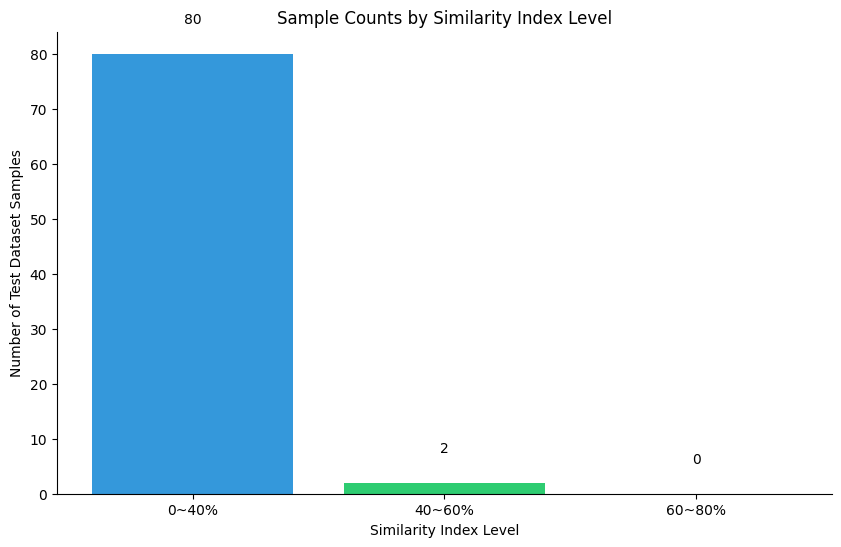

In [16]:
import matplotlib.pyplot as plt


thresholds = similarity_index_levels
sample_counts = [(test_dataset['similarity_index_level'] == x).sum() for x in thresholds]



colors = ['#3498db', '#2ecc71', '#e74c3c']  


plt.figure(figsize=(10, 6)) 
plt.bar(thresholds, sample_counts, color=colors)
ax = plt.gca()  
ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False) 

plt.title('Sample Counts by Similarity Index Level')
plt.xlabel('Similarity Index Level')
plt.ylabel('Number of Test Dataset Samples')


for i, count in enumerate(sample_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')


plt.show()


In [17]:
test_dataset.to_csv(os.path.join(dataset_path, 'test_dataset_with_similarity_idx.csv'), index=False)